In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('results_detailed.csv')
df.columns

Index(['epoch', 'question', 'options', 'true_answer', 'predicted_answer',
       'correct', 'char_count', 'time_seconds', 'thinking_mode', 'prompt_mode',
       'main_model', 'small_model'],
      dtype='object')

# Question 1: Do Hybrid Reasoners Maintain High Predictive Accuracy

Show bar plot of highest reasoning, non-reasoning, and hybrid models

In [3]:
# Get unique thinking modes
thinking_modes = df['thinking_mode'].unique()

# Store best configs and their stats for each thinking mode
best_models = {}

for mode in thinking_modes:
    # Filter data for this thinking mode
    mode_data = df[df['thinking_mode'] == mode]
    
    # Group by config and calculate mean accuracy
    config_stats = mode_data.groupby(['prompt_mode', 'main_model', 'small_model'])['correct'].agg(['mean', 'std', 'count']).reset_index()
    
    # Find config with highest mean accuracy
    best_config = config_stats.loc[config_stats['mean'].idxmax()]
    
    # Get corresponding data for this best config
    best_config_data = mode_data[
        (mode_data['prompt_mode'] == best_config['prompt_mode']) & 
        (mode_data['main_model'] == best_config['main_model']) & 
        (mode_data['small_model'] == best_config['small_model'])
    ]
    
    # Store results
    mode_str = 'Non-Reasoner'
    if mode == 1:
        mode_str = 'Reasoner'
    elif mode == 2:
        mode_str = 'Hybrid Reasoner (Ours)'
    config_str = mode_str

    best_models[mode] = best_config_data

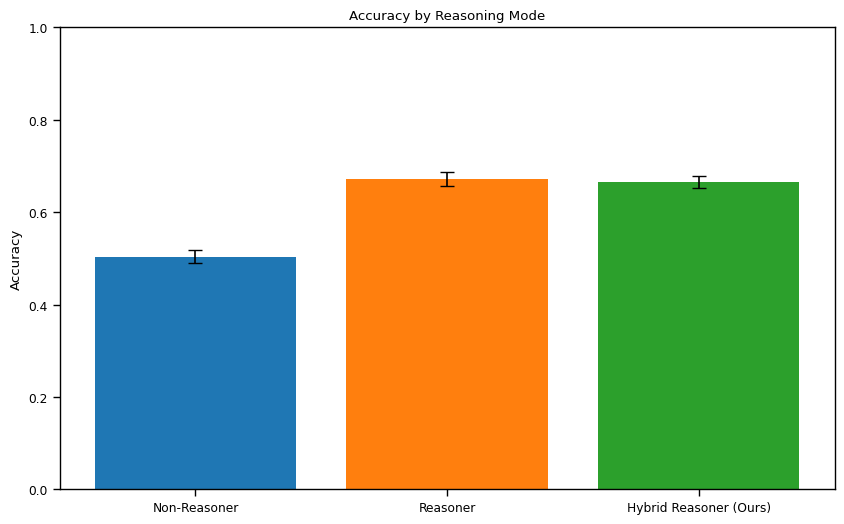

In [4]:
# Make bar graph of best models accuracy
import seaborn as sns

# Set seaborn style
sns.set_context("paper")

# Create lists to store data for plotting
modes = []
means = []
std_errs = []

# Calculate mean and standard error for each best model
for mode in range(len(best_models)):
    data = best_models[mode]
    mode_str = 'Non-Reasoner'
    if mode == 1:
        mode_str = 'Reasoner'
    elif mode == 2:
        mode_str = 'Hybrid Reasoner (Ours)'
        
    modes.append(mode_str)
    means.append(data['correct'].mean())
    std_errs.append(data['correct'].std() / np.sqrt(len(data)))

# Create bar plot with different colors
plt.figure(figsize=(10, 6))
colors = sns.color_palette()
bars = plt.bar(modes, means, yerr=std_errs, capsize=5, color=colors[:len(modes)])

# Customize plot
plt.ylabel('Accuracy')
plt.title('Accuracy by Reasoning Mode')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 since these are accuracies

plt.show()


# Question 2: What is the Relationship between Reasoning Compute and Accuracy for Hybrid Models?

- line plot where x is total number of model parameters for our approach (small model + big), y axis is number of seconds to produce prediction, horizontal line for best reasoning model/non-reasoning model

- line plot where x is total number of model parameters for our approach (small model + big), y axis is number of tokens to produce prediction, horizontal line for best reasoning model/non-reasoning model

Each of these plots should share a y axis with accuracy as a function of model size.

only use data for best accuracy's prompt mode (i.e. tokens, relative, seconds, etc.)

In [14]:
# Get best hybrid model info and make helper functions
best_hybrid = best_models[2]
best_hybrid.columns
def compute_model_size(main_model, small_model):
    def compute_single_size(model):
        if '0.6B' in model:
            return 0.6
        elif '1.7B' in model:
            return 1.7
        elif '4B' in model:
            return 4
        else:
            return 0
    return compute_single_size(main_model) + compute_single_size(small_model)

best_prompt_mode = best_hybrid['prompt_mode'].unique()[0]

In [ ]:
# Filter for thinking mode 2 and best prompt mode
hybrid_data = df[(df['thinking_mode'] == 2) & (df['prompt_mode'] == best_prompt_mode)]

# Calculate model sizes and accuracies
model_size_accuracies = {}
model_size_times = {}
model_size_chars = {}
for _, row in hybrid_data.iterrows():
    model_size = compute_model_size(row['main_model'], row['small_model'])
    if model_size not in model_size_accuracies:
        model_size_accuracies[model_size] = []
        model_size_times[model_size] = []
        model_size_chars[model_size] = []
    model_size_accuracies[model_size].append(row['correct'])
    model_size_times[model_size].append(row['time_seconds'])
    model_size_chars[model_size].append(row['char_count'])




dict_keys([1.2, 4.6, 2.3, 5.7, 3.4, 8])

# Question 3: Through what mechanisms should meta-reasoners structure their thoughts?

- line plot where x is total number of model parameters for our approach (small model + big), y axis is accuracy, different lines for each of the different variations we try (tell big model how long to think in terms of language, such as "don't think too hard", seconds, or tokens), horizontal line for best reasoning model/non-reasoning model

# Random bs to get initial plots

In [ ]:
# Get unique thinking modes
thinking_modes = df['thinking_mode'].unique()

# Store best configs and their stats for each thinking mode
best_configs = []
accuracies = []
acc_std_errors = []
times = []
time_std_errors = []
chars = []
char_std_errors = []

for mode in thinking_modes:
    # Filter data for this thinking mode
    mode_data = df[df['thinking_mode'] == mode]
    
    # Group by config and calculate mean accuracy
    config_stats = mode_data.groupby(['prompt_mode', 'main_model', 'small_model'])['correct'].agg(['mean', 'std', 'count']).reset_index()
    
    # Find config with highest mean accuracy
    best_config = config_stats.loc[config_stats['mean'].idxmax()]
    
    # Get corresponding data for this best config
    best_config_data = mode_data[
        (mode_data['prompt_mode'] == best_config['prompt_mode']) & 
        (mode_data['main_model'] == best_config['main_model']) & 
        (mode_data['small_model'] == best_config['small_model'])
    ]
    
    # Store results
    mode_str = 'Non-Reasoner'
    if mode == 1:
        mode_str = 'Reasoner'
    elif mode == 2:
        mode_str = 'Hybrid Reasoner (Ours)'
    config_str = f"{mode_str}"
    best_configs.append(config_str)
    
    # Accuracy stats
    accuracies.append(best_config['mean'])
    acc_std_errors.append(best_config['std'] / np.sqrt(best_config['count']))
    
    # Time stats
    times.append(best_config_data['time_seconds'].mean())
    time_std_errors.append(best_config_data['time_seconds'].std() / np.sqrt(len(best_config_data)))
    
    # Character count stats  
    chars.append(best_config_data['char_count'].mean())
    char_std_errors.append(best_config_data['char_count'].std() / np.sqrt(len(best_config_data)))

# Define colors for each thinking mode
colors = sns.color_palette('husl', n_colors=len(thinking_modes))

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy plot
bars1 = ax1.bar(best_configs, accuracies, yerr=acc_std_errors, capsize=5, color=colors)
ax1.set_xlabel('Thinking Mode', labelpad=20)
ax1.set_ylabel('Mean Accuracy')
ax1.set_title('Accuracy by Thinking Mode')
# for bar, acc in zip(bars1, accuracies):
#     ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f'{acc:.3f}', ha='center', va='bottom')

# Time plot
bars2 = ax2.bar(best_configs, times, yerr=time_std_errors, capsize=5, color=colors)
ax2.set_xlabel('Thinking Mode', labelpad=20)
ax2.set_ylabel('Mean Time (seconds)')
ax2.set_title('Response Time by Thinking Mode')
# for bar, time in zip(bars2, times):
#     ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f'{time:.1f}', ha='center', va='bottom')

# Character count plot
bars3 = ax3.bar(best_configs, chars, yerr=char_std_errors, capsize=5, color=colors)
ax3.set_xlabel('Thinking Mode', labelpad=20)
ax3.set_ylabel('Mean Character Count')
ax3.set_title('Response Length by Thinking Mode')
# for bar, char in zip(bars3, chars):
#     ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f'{char:.0f}', ha='center', va='bottom')

plt.tight_layout()

# Rotate x-axis labels if needed
# plt.xticks(rotation=45, ha='right')

# # Add value labels on top of bars
# for bar, acc in zip(bars, accuracies):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('accuracy_by_thinking_mode.png')
plt.show()
plt.close()
